#  Spike PAtterns DEtection using SPADE


In [1]:
import numpy as np
import quantities as pq
import neo
import elephant
import viziphant
np.random.seed(4542)

## introducing heterogeneous delays

the function developed in the scan + a shift in time

In [36]:
t_stop = 400*pq.ms
slope = 4.
A_sync = 0.15
shift = 0.0
A = [0]+[1.-A_sync]+[0]*8+[A_sync]
spiketrains = elephant.spike_train_generation.compound_poisson_process(
                             rate=5*pq.Hz, A=A, shift=shift*pq.ms, t_stop=t_stop)
                             


Add a shift:

In [37]:
spiketrains[0].times + 4.2*pq.s

array([4542.91570369]) * ms

Wrap around time:

In [38]:
np.sort(np.mod(spiketrains[0].times + 4.2*pq.ms, 1000.*pq.ms))

array([347.11570369]) * ms

Sort in time:

In [39]:
np.sort(np.mod(spiketrains[0].times + 4.2*pq.ms, 1000.*pq.ms))

array([347.11570369]) * ms

https://neo.readthedocs.io/en/stable/core.html?highlight=spiketrain#example-spiketrain

In [40]:
neo.SpikeTrain(np.sort(np.mod(spiketrains[0].times + 4.2*pq.s, 1000.*pq.ms)), t_start=0*pq.ms, t_stop=1000.*pq.ms)



SpikeTrain

In [41]:
for i_st in range(10):
    delay = (i_st*slope)*pq.ms
    spike_times = np.sort(np.mod(spiketrains[i_st].times + delay, t_stop))
    spiketrains[i_st] = neo.SpikeTrain(spike_times, t_start=0*pq.ms, t_stop=t_stop)

In [42]:
print(slope, 'max delay=', 10*slope, 'ms')

4.0 max delay= 40.0 ms


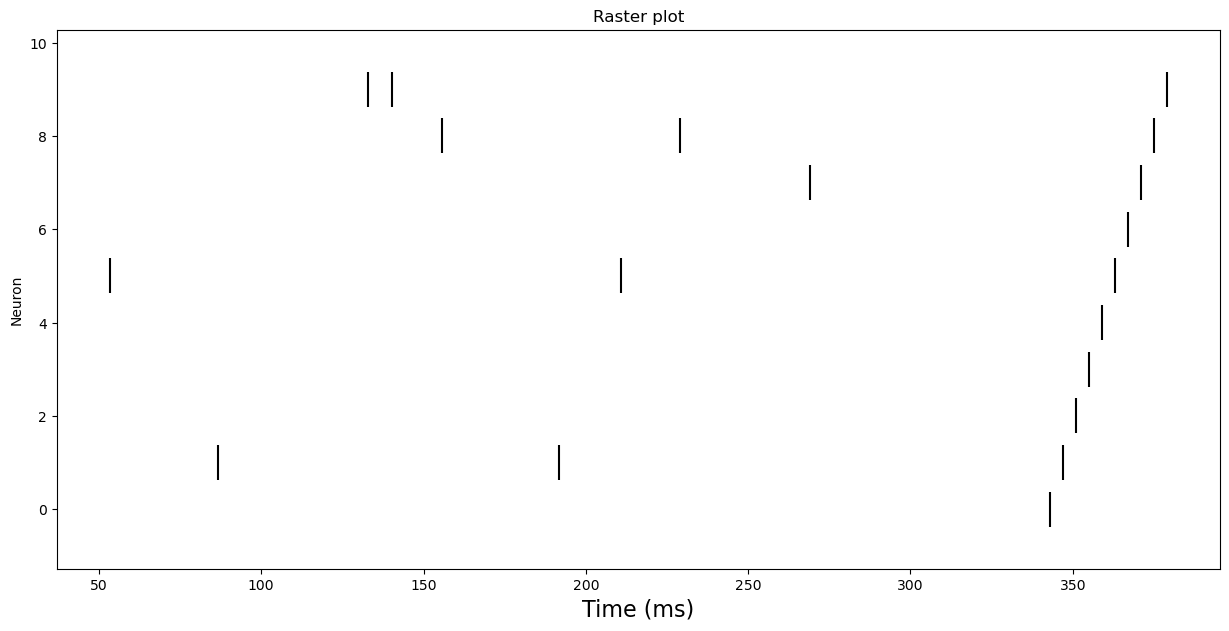

In [43]:

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.eventplot([spiketrains[i].magnitude for i in range(len(spiketrains))], linelengths=0.75, color='black')
plt.xlabel('Time (ms)', fontsize=16)
plt.ylabel('Neuron')
plt.title("Raster plot");

In [ ]:
from brainhack import printfig
printfig(fig, 'raster_plot_linearpattern')

All in one function:

In [48]:
t_stop = 10000*pq.ms
def generate_and_test(A_sync=A_sync, shift=shift, winlen=1, slope=slope, t_stop=t_stop):

    A = [0]+[1.-A_sync]+[0]*8+[A_sync]
    spiketrains = elephant.spike_train_generation.compound_poisson_process(
                             rate=5*pq.Hz, A=A, shift=shift*pq.ms, t_stop=t_stop)
    for i_st in range(10):
        delay = (i_st*slope)*pq.ms
        spike_times = np.sort(np.mod(spiketrains[i_st].times + delay, t_stop))
        spiketrains[i_st] = neo.SpikeTrain(spike_times, t_start=0*pq.ms, t_stop=t_stop)

    for i in range(90):
        spiketrains.append(elephant.spike_train_generation.homogeneous_poisson_process(
            rate=5*pq.Hz, t_stop=t_stop))
    patterns = elephant.spade.spade(
                                spiketrains=spiketrains, binsize=1*pq.ms, winlen=winlen, min_spikes=3,
                                n_surr=100, dither=5*pq.ms,
                                psr_param=[0,0,0],
                                output_format='patterns')['patterns']
    return patterns


* changing the synchrony probability to check when SPADE will begin to fail:


In [49]:
for slope_ in np.logspace(-1, 1, 10, base=10):
    patterns = generate_and_test(slope=slope_)
    print(slope_, 'max delay=', 10*slope, 'ms: ', patterns)

/Users/laurentperrinet/opt/anaconda3/envs/brainhack/lib/python3.9/site-packages/elephant/spade.py:679: UserWarning: Optimized C implementation of FCA (fim.so/fim.pyd) not found in elephant/spade_src folder, or not compatible with this Python version. You are using the pure Python implementation of fast fca.
  warnings.warn(


Time for data mining: 28.213847875595093
Time for pvalue spectrum computation: 1253.4751369953156
0.1 max delay= 40.0 ms:  []
Time for data mining: 16.484561920166016
Time for pvalue spectrum computation: 1284.2360949516296
0.16681005372000587 max delay= 40.0 ms:  [{'itemset': (33, 3, 4), 'windows_ids': (1538, 8695), 'neurons': [33, 3, 4], 'lags': array([0., 0.]) * ms, 'times': array([1538., 8695.]) * ms, 'signature': (3, 2), 'pvalue': 1.0}]
Time for data mining: 11.799942970275879
Time for pvalue spectrum computation: 1188.7150299549103
0.2782559402207124 max delay= 40.0 ms:  [{'itemset': (2, 3, 4), 'windows_ids': (6308, 2574, 7984, 2962, 6237, 5975, 2461, 5758), 'neurons': [2, 3, 4], 'lags': array([0., 0.]) * ms, 'times': array([2461., 2574., 2962., 5758., 5975., 6237., 6308., 7984.]) * ms, 'signature': (3, 8), 'pvalue': 0.0}, {'itemset': (4, 5, 6), 'windows_ids': (636, 8292, 3206, 7464, 1352, 3304, 3947, 1741, 3886, 1904, 9361, 3952, 6393, 1978, 7580), 'neurons': [4, 5, 6], 'lags': 

In [ ]:
for slope_ in np.logspace(-1, 1, 10, base=10):
    patterns = generate_and_test(slope=slope_, winlen=10)
    print(slope_, 'max delay=', 10*slope, 'ms: ', patterns)

ValueError: (ValueError('The input must have the same units.'), 'If you want to bin over the shared [t_start, t_stop] interval, provide shared t_start and t_stop explicitly, which can be obtained like so: t_start, t_stop = elephant.utils.get_common_start_stop_times(spiketrains)')